<a href="https://colab.research.google.com/github/mchchoi/factorization/blob/main/LiftedMH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Q: acceptance rate (state-changes only) = 0.4995
P: move counts over T-1 steps: {'Q': 125500, 'drift': 124745, 'flip': 249754}


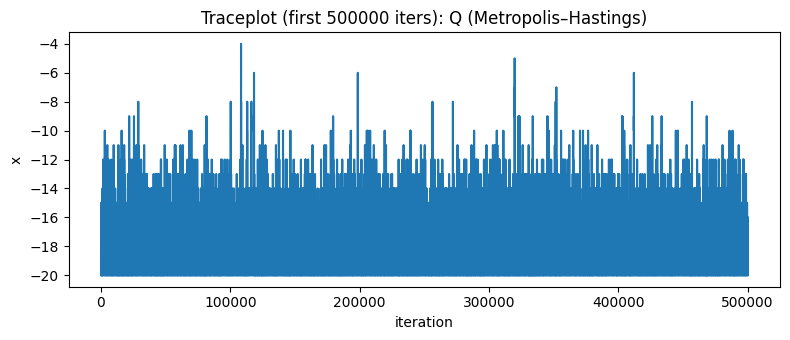

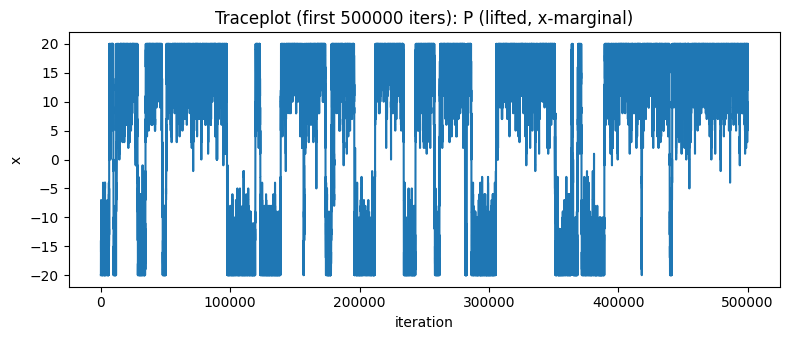

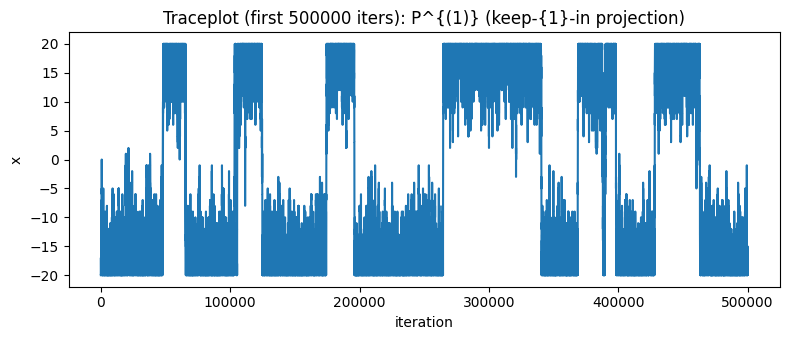

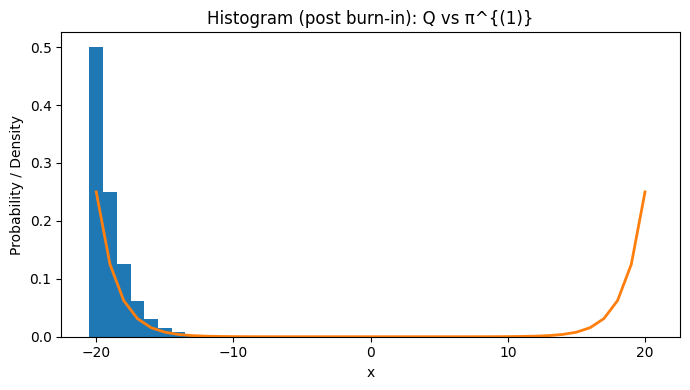

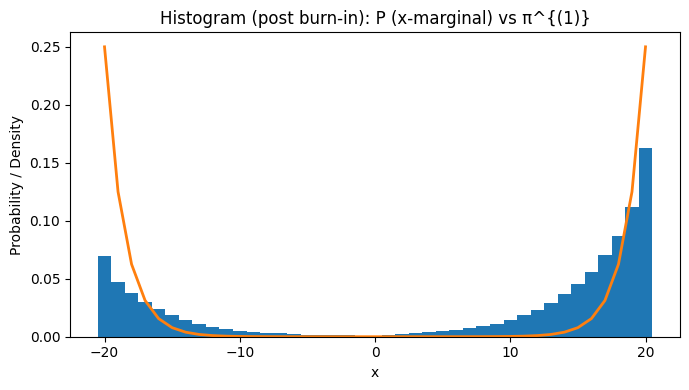

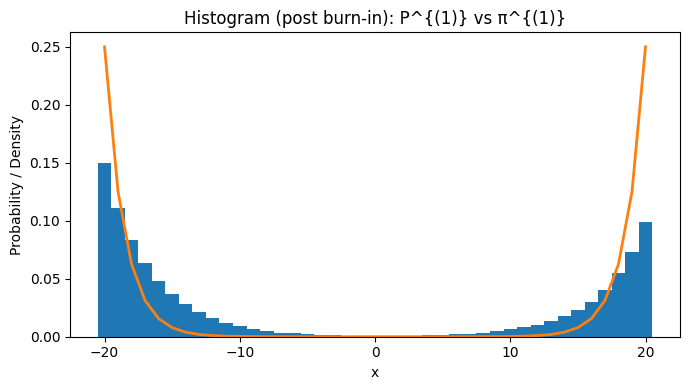


Empirical vs True Moments:
            Sampler     Mean  Variance  ΔMean (emp - true)  ΔVar (emp - true)
            Q (MH) -19.0027    1.9819            -19.0027          -361.0184
P (lifted, x-only)   6.7105  239.5813              6.7105          -123.4189
           P^{(1)}  -3.5397  286.6007             -3.5397           -76.3995
     Truth π^{(1)}   0.0000  363.0003              0.0000             0.0000


In [42]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Simulate and compare three MCMC samplers on a finite state space:
  Q  : Metropolis–Hastings on X^{(1)} = {-n, ..., n}
  P  : Lifted run-and-tumble sampler on X = X^{(1)} × {-1,+1}, with position moves via Q
  P1 : Keep-{1}-in projection sampler induced by one step of P after drawing v ~ Unif{-1,+1}

Target:
  π^{(1)}(x) ∝ 2^{|x|}, x ∈ {-n,...,n}

Proposal M (for Q):
  From x, propose y = clip(x + d) where d ∈ {-1,+1} uniformly. This implies
  M(x, y) = 1/2 if y = clip(x±1), and 0 otherwise.

Lifted kernel P parameters:
  With probability a: (x, v) -> (y, v) by applying a single Q step to x
  With probability b: (x, v) -> (clip(x+v), v)
  With probability c: (x, v) -> (x, -v)
  (Require a + b + c = 1)

P^{(1)} step:
  From x, draw v ~ Unif{-1,+1}; apply one P step to (x, v); return only the new position y.

Produces:
  - Trace plots (first trace_len iters) for Q, P (x only), and P^{(1)}
  - Histograms (post burn-in) overlaid with the true π^{(1)}

Usage:
  python sim_lifted_projection_mcmc.py
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Dict

# ---------------------- Configuration ----------------------
SEED = 10240
#11240
rng = np.random.default_rng(SEED)

n = 20                                  # state space is {-n, ..., n}
a = 1/4                                  # probability of Q-move inside P
b = 1/4                                  # probability of deterministic move along v
c = 1/2                                  # probability of flipping v

T = 500000                                # total iterations per chain
burn = 1                              # burn-in for histograms
trace_len = 500000                         # how many iterations to show in trace plot

# ---------------------- Target and helpers ----------------------
xs = np.arange(-n, n+1)

# Unnormalized target weights w(x) = 2^{|x|}
w = np.array([2**abs(x) for x in xs], dtype=np.float64)
pi = w / w.sum()                         # normalized π^{(1)}
w_lookup: Dict[int, float] = {int(x): float(2**abs(x)) for x in xs}

def clip_state(x: int) -> int:
    return int(np.clip(x, -n, n))

def M_prob(x: int, y: int) -> float:
    """Proposal probability M(x,y): y = clip(x±1) with prob 1/2; 0 otherwise."""
    if y == clip_state(x + 1) or y == clip_state(x - 1):
        return 0.5
    return 0.0

def propose_M(x: int) -> int:
    d = 1 if rng.random() < 0.5 else -1
    return clip_state(x + d)

def mh_step_Q(x: int) -> Tuple[int, bool]:
    """One MH step under Q with proposal M and target π^{(1)} ∝ w.
    Returns (new_x, accepted_move_that_changed_state)."""
    y = propose_M(x)
    num = w_lookup[y] * M_prob(y, x)
    den = w_lookup[x] * M_prob(x, y)
    alpha = 1.0 if num >= den else (num / den)
    if rng.random() < alpha:
        accepted = (y != x)
        return y, accepted
    else:
        return x, False

def p_step(x: int, v: int):
    """One step of lifted P. Returns (x_new, v_new, which_move)."""
    u = rng.random()
    if u < a:
        x_new, _ = mh_step_Q(x)
        return x_new, v, 'Q'
    elif u < a + b:
        x_new = clip_state(x + v)
        return x_new, v, 'drift'
    else:
        return x, -v, 'flip'

def p1_step(x: int) -> int:
    v = 1 if rng.random() < 0.5 else -1
    x_new, _v_new, _which = p_step(x, v)
    return x_new

# ---------------------- Simulate the three chains ----------------------
def simulate_Q(x0: int):
    chain = np.empty(T, dtype=int)
    chain[0] = x0
    accepts_changed = 0
    for t in range(1, T):
        chain[t], acc = mh_step_Q(chain[t-1])
        accepts_changed += int(acc)
    acc_rate_changed = accepts_changed / (T - 1)
    return chain, acc_rate_changed

def simulate_P(x0: int, v0: int):
    x_chain = np.empty(T, dtype=int)
    v_chain = np.empty(T, dtype=int)
    x_chain[0], v_chain[0] = x0, v0
    move_counts = {'Q': 0, 'drift': 0, 'flip': 0}
    for t in range(1, T):
        x_new, v_new, which = p_step(x_chain[t-1], v_chain[t-1])
        x_chain[t], v_chain[t] = x_new, v_new
        move_counts[which] += 1
    return x_chain, v_chain, move_counts

def simulate_P1(x0: int):
    chain = np.empty(T, dtype=int)
    chain[0] = x0
    for t in range(1, T):
        chain[t] = p1_step(chain[t-1])
    return chain

# ---------------------- Run ----------------------
if __name__ == "__main__":
    x0 = -20
    v0 = 1 if rng.random() < 0.5 else -1

    Q_chain, Q_acc_rate = simulate_Q(x0)
    P_x_chain, P_v_chain, P_move_counts = simulate_P(x0, v0)
    P1_chain = simulate_P1(x0)

    print("Q: acceptance rate (state-changes only) =", round(Q_acc_rate, 4))
    print("P: move counts over T-1 steps:", P_move_counts)

    def traceplot(chain: np.ndarray, title: str):
        plt.figure(figsize=(8, 3.5))
        plt.plot(np.arange(min(trace_len, len(chain))), chain[:trace_len])
        plt.xlabel("iteration")
        plt.ylabel("x")
        plt.title(title)
        plt.tight_layout()
        plt.show()

    traceplot(Q_chain, f"Traceplot (first {trace_len} iters): Q (Metropolis–Hastings)")
    traceplot(P_x_chain, f"Traceplot (first {trace_len} iters): P (lifted, x-marginal)")
    traceplot(P1_chain, f"Traceplot (first {trace_len} iters): P^{{(1)}} (keep-{{1}}-in projection)")

    bins = np.arange(-n - 0.5, n + 1.5, 1.0)

    def hist_with_pi(samples: np.ndarray, title: str):
        plt.figure(figsize=(7, 4))
        plt.hist(samples, bins=bins, density=True)
        plt.plot(xs, pi, linewidth=2)
        plt.xlabel("x")
        plt.ylabel("Probability / Density")
        plt.title(title)
        plt.tight_layout()
        plt.show()

    hist_with_pi(Q_chain[burn:], "Histogram (post burn-in): Q vs π^{(1)}")
    hist_with_pi(P_x_chain[burn:], "Histogram (post burn-in): P (x-marginal) vs π^{(1)}")
    hist_with_pi(P1_chain[burn:], "Histogram (post burn-in): P^{(1)} vs π^{(1)}")

# ---------------------- Table: empirical vs true moments ----------------------
    def summarize(samples: np.ndarray):
        return float(np.mean(samples)), float(np.var(samples))

    S_Q  = Q_chain[burn:]
    S_Px = P_x_chain[burn:]
    S_P1 = P1_chain[burn:]

    mu_true  = float(np.sum(xs * pi))
    var_true = float(np.sum((xs - mu_true)**2 * pi))

    mQ, vQ   = summarize(S_Q)
    mP, vP   = summarize(S_Px)
    mP1, vP1 = summarize(S_P1)

    df = pd.DataFrame([
        ["Q (MH)",             mQ,  vQ,  mQ  - mu_true,  vQ  - var_true],
        ["P (lifted, x-only)", mP,  vP,  mP  - mu_true,  vP  - var_true],
        ["P^{(1)}",            mP1, vP1, mP1 - mu_true,  vP1 - var_true],
        ["Truth π^{(1)}",      mu_true, var_true, 0.0, 0.0],
    ], columns=["Sampler", "Mean", "Variance", "ΔMean (emp - true)", "ΔVar (emp - true)"]).round(4)

    print("\nEmpirical vs True Moments:\n", df.to_string(index=False))


In [47]:
def empirical_pmf(samples: np.ndarray, support: np.ndarray) -> np.ndarray:
    counts = np.bincount(samples - support[0], minlength=len(support))
    return counts / counts.sum()

def tv_dist(p, q): return 0.5 * np.abs(p - q).sum()

def kl_div(p, q):
    mask = p > 0
    return float(np.sum(p[mask] * (np.log(p[mask]) - np.log(q[mask]))))

def all_metrics(p_emp, p_true, support):
    return dict(
        TV = tv_dist(p_emp, p_true),
        KL_emp_true = kl_div(p_emp, p_true),
    )

p_Q  = empirical_pmf(S_Q,  xs)
p_P  = empirical_pmf(S_Px, xs)
p_P1 = empirical_pmf(S_P1, xs)

rows = []
for name, p_emp in [("Q (MH)", p_Q), ("P (lifted, x-only)", p_P), ("P^{(1)}", p_P1)]:
  met = all_metrics(p_emp, pi, xs)
  met["Sampler"] = name
  rows.append(met)

df_met = pd.DataFrame(rows)[["Sampler","TV","KL_emp_true"]].round(6)
print("\nHistogram vs Truth Metrics:\n", df_met.to_string(index=False))
#df_met.to_csv("hist_vs_truth_metrics.csv", index=False)



Histogram vs Truth Metrics:
            Sampler       TV  KL_emp_true
            Q (MH) 0.500003     0.693184
P (lifted, x-only) 0.384396     0.867671
           P^{(1)} 0.324548     0.565064
